# **Predicting SME Performance from Digital Transformation Indicators**

In [1]:
# !pip install catboost

In [16]:
# =========================================================
# 1. IMPORTS
# =========================================================

import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Explainable AI
import shap

# Causal inference
from sklearn.neighbors import NearestNeighbors

In [3]:
# 2. LOAD DATA
# -------------------------
df = pd.read_csv("african_sme_digital_transformation.csv")

print("Initial shape:", df.shape)
df.head()

Initial shape: (1000, 12)


,company_id,country,sector,employees,annual_revenue,tech_adoption_level,main_challenges,digital_tools_used,growth_last_yr,funding_status,female_owned,remote_work_policy
0,1,Ghana,Education,130,386441,Low,Awareness,"CRM, WhatsApp, E-commerce",11,Seed,No,NaN
1,2,Rwanda,Farming,367,383576,Low,Internet,WhatsApp,27,Series A,Yes,Partial
2,3,Kenya,Farming,87,496528,Low,"Awareness, Internet","Google My Business, Mobile money, POS",1,Bootstrapped,No,Full
3,4,Kenya,Manufacturing,131,360550,High,Regulation,"Google My Business, E-commerce, POS",6,NaN,Yes,Full
4,5,Nigeria,Logistics,136,173801,High,"Regulation, Skills",E-commerce,44,Series A,Yes,Partial


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   company_id           1000 non-null   int64 
 1   country              1000 non-null   object
 2   sector               1000 non-null   object
 3   employees            1000 non-null   int64 
 4   annual_revenue       1000 non-null   int64 
 5   tech_adoption_level  1000 non-null   object
 6   main_challenges      1000 non-null   object
 7   digital_tools_used   1000 non-null   object
 8   growth_last_yr       1000 non-null   int64 
 9   funding_status       746 non-null    object
 10  female_owned         1000 non-null   object
 11  remote_work_policy   677 non-null    object
dtypes: int64(4), object(8)
memory usage: 93.9+ KB
None
        company_id    employees  annual_revenue  growth_last_yr
count  1000.000000  1000.000000     1000.000000     1000.000000
mean    500.500000   257

In [5]:
# 3. DATA CLEANING
# -------------------------

# Missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Duplicate rows
print("\nDuplicate rows:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()

# Drop rows with missing target
df = df.dropna(subset=["growth_last_yr"])

print("Shape after cleaning:", df.shape)


Missing values per column:
 company_id               0
country                  0
sector                   0
employees                0
annual_revenue           0
tech_adoption_level      0
main_challenges          0
digital_tools_used       0
growth_last_yr           0
funding_status         254
female_owned             0
remote_work_policy     323
dtype: int64

Duplicate rows: 0
Shape after cleaning: (1000, 12)


In [6]:
# 4. FEATURE ENGINEERING
# -------------------------

# Encode tech adoption (ordinal)
tech_map = {"Low": 1, "Medium": 2, "High": 3}
df["tech_adoption_encoded"] = df["tech_adoption_level"].map(tech_map)

# Convert female_owned to binary (FIXES ERROR)
df["female_owned"] = df["female_owned"].map({"Yes": 1, "No": 0})

# Digital tools to binary
tools = ["CRM", "WhatsApp", "E-commerce", "POS", "Google My Business", "Mobile money"]

for tool in tools:
    df[f"tool_{tool.replace(' ', '_')}"] = (
        df["digital_tools_used"].str.contains(tool, case=False, na=False).astype(int)
    )

# Digital tool count
tool_cols = [c for c in df.columns if c.startswith("tool_")]
df["digital_tool_count"] = df[tool_cols].sum(axis=1)

# Log revenue
df["log_annual_revenue"] = np.log1p(df["annual_revenue"])

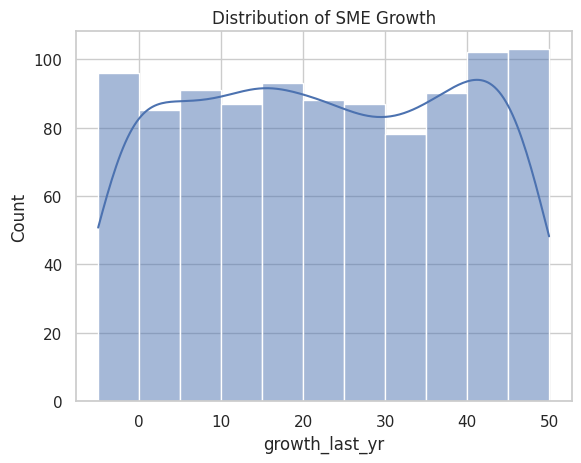

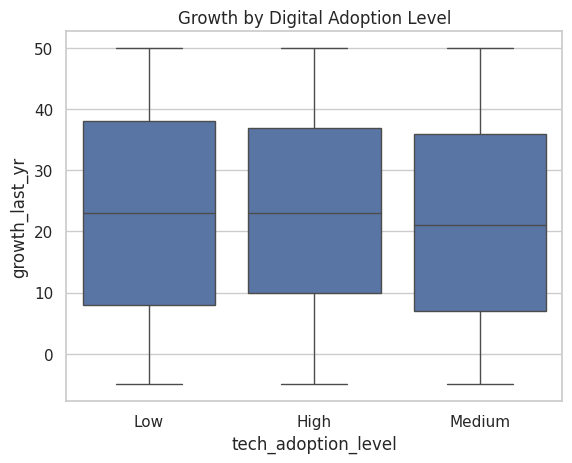

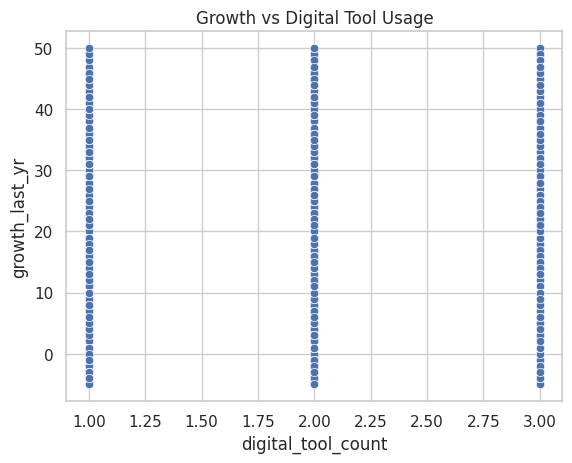

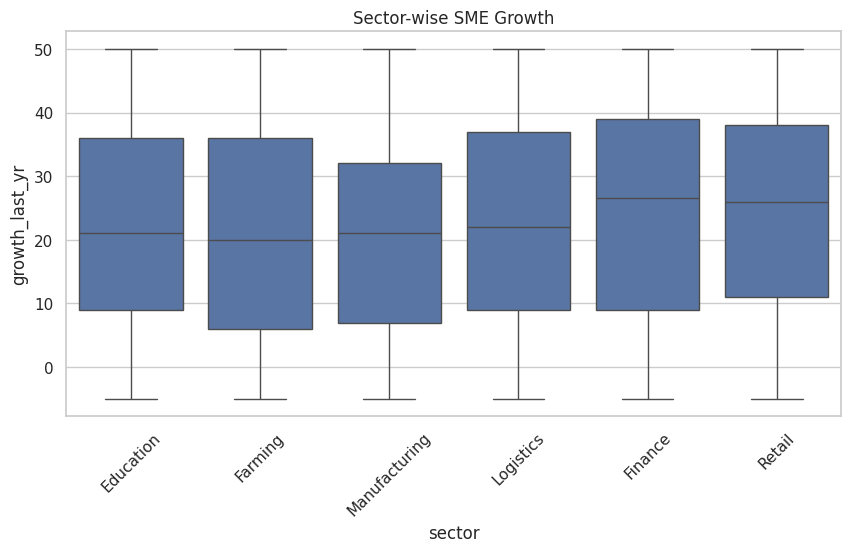

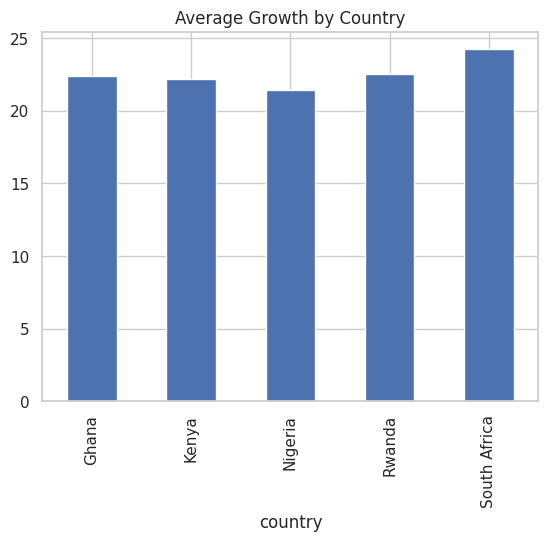

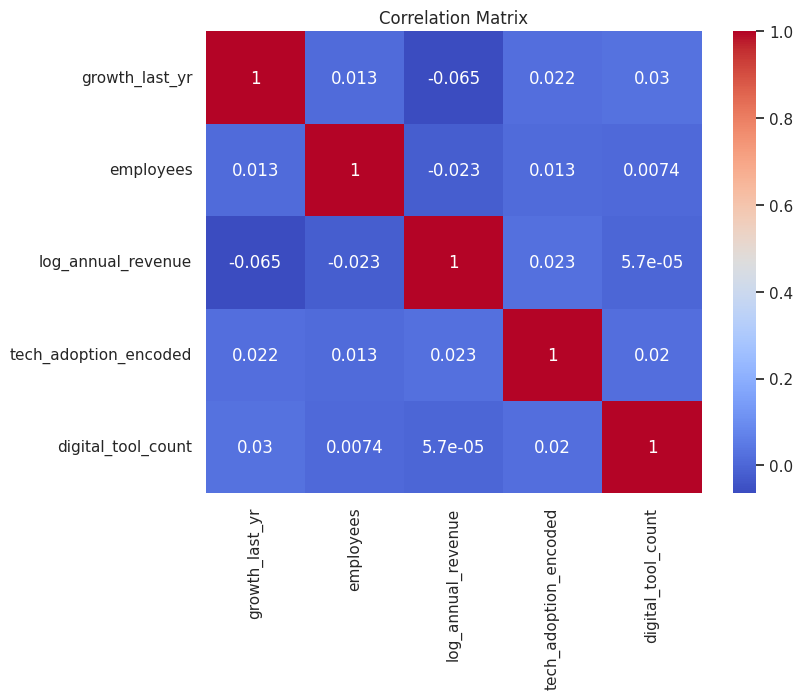

In [7]:
# 5. EXPLORATORY DATA ANALYSIS (EDA)
# -------------------------

sns.set(style="whitegrid")

# Plot 1: Growth distribution
plt.figure()
sns.histplot(df["growth_last_yr"], kde=True)
plt.title("Distribution of SME Growth")
plt.show()

# Plot 2: Growth vs tech adoption
plt.figure()
sns.boxplot(x="tech_adoption_level", y="growth_last_yr", data=df)
plt.title("Growth by Digital Adoption Level")
plt.show()

# Plot 3: Growth vs digital tool count
plt.figure()
sns.scatterplot(x="digital_tool_count", y="growth_last_yr", data=df)
plt.title("Growth vs Digital Tool Usage")
plt.show()

# Plot 4: Sector-wise growth
plt.figure(figsize=(10, 5))
sns.boxplot(x="sector", y="growth_last_yr", data=df)
plt.xticks(rotation=45)
plt.title("Sector-wise SME Growth")
plt.show()

# Plot 5: Country-wise average growth
plt.figure()
df.groupby("country")["growth_last_yr"].mean().plot(kind="bar")
plt.title("Average Growth by Country")
plt.show()

# Plot 6: Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    df[["growth_last_yr", "employees", "log_annual_revenue",
        "tech_adoption_encoded", "digital_tool_count"]].corr(),
    annot=True, cmap="coolwarm"
)
plt.title("Correlation Matrix")
plt.show()

In [8]:
# 6. DEFINE FEATURES & TARGET
# -------------------------

target = "growth_last_yr"

numerical_features = [
    "employees",
    "log_annual_revenue",
    "tech_adoption_encoded",
    "digital_tool_count",
    "female_owned"
]

categorical_features = [
    "country",
    "sector",
    "funding_status",
    "remote_work_policy"
]

X = df[numerical_features + categorical_features]
y = df[target]

In [9]:
# 7. PREPROCESSING PIPELINE
# -------------------------

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [10]:
# 8. TRAIN–TEST SPLIT
# -------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [11]:
# 9. HYPERPARAMETER TUNING (ADVANCED AI)
# -------------------------

xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(objective="reg:squarederror", random_state=42))
])

param_grid = {
    "model__n_estimators": [200, 300],
    "model__max_depth": [4, 6],
    "model__learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(
    xgb_pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_

In [12]:
# 10. MODELS
# -------------------------

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": best_xgb.named_steps["model"],
    "CatBoost": CatBoostRegressor(
        iterations=500, depth=6, learning_rate=0.05,
        loss_function="RMSE", verbose=0, random_state=42
    )
}

results = []
fitted = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    })
    fitted[name] = pipe

results_df = pd.DataFrame(results)
print(results_df)

           Model       RMSE        MAE        R2
0         Linear  17.060716  14.956216  0.005471
1          Ridge  17.060010  14.955721  0.005553
2  Random Forest  17.591506  15.293400 -0.057375
3        XGBoost  17.942688  15.369008 -0.100014
4       CatBoost  17.985656  15.616524 -0.105288


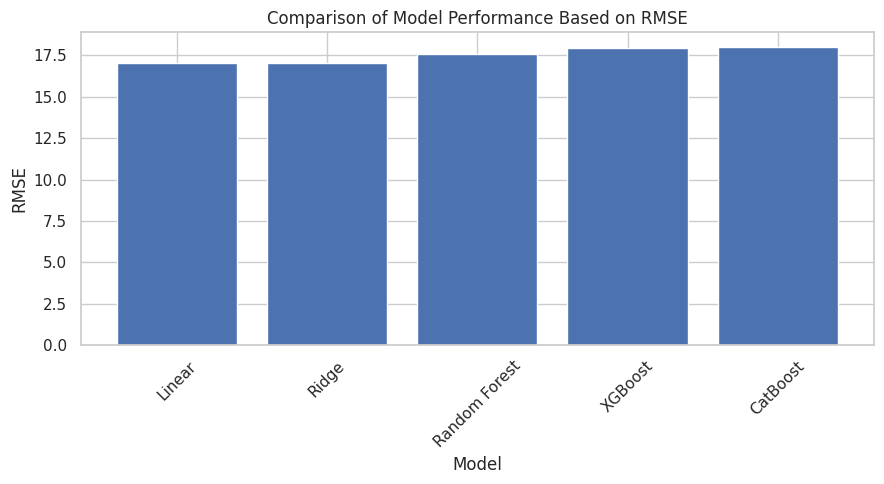

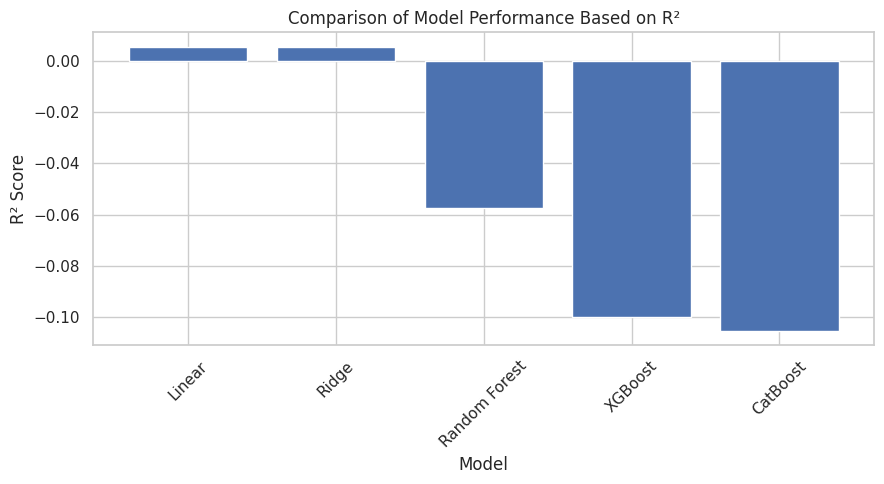

In [13]:
# 11. Comparison

# Single bar chart
plt.figure(figsize=(9, 5))
plt.bar(results_df["Model"], results_df["RMSE"])
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.title("Comparison of Model Performance Based on RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9, 5))
plt.bar(results_df["Model"], results_df["R2"])
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.title("Comparison of Model Performance Based on R²")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 97%|=================== | 730/750 [00:26<00:00]       

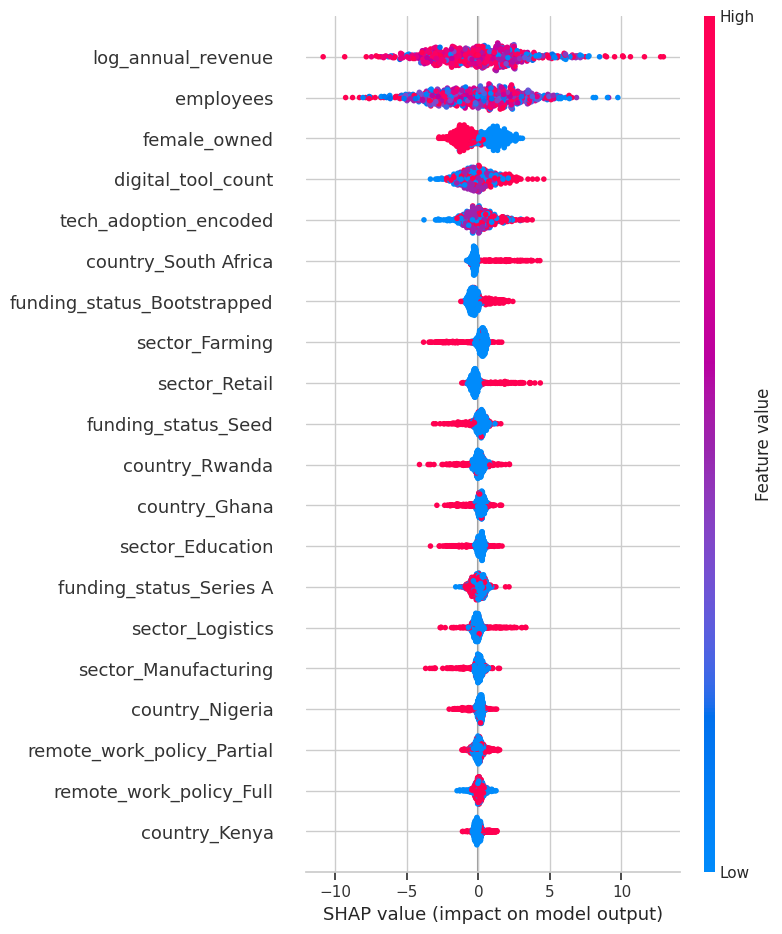

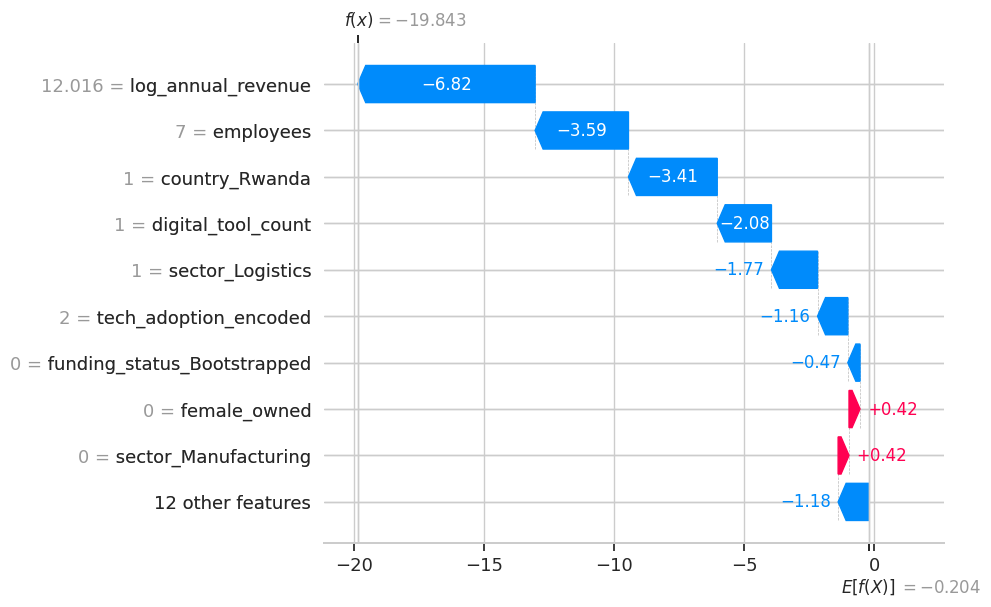

In [14]:
# 12. EXPLAINABLE AI (GLOBAL + LOCAL SHAP)
# -------------------------

best_model = fitted["CatBoost"]

X_train_proc = preprocessor.fit_transform(X_train)
feature_names = (
    numerical_features +
    list(
        preprocessor.named_transformers_["cat"]
        .named_steps["onehot"]
        .get_feature_names_out(categorical_features)
    )
)

explainer = shap.Explainer(best_model.named_steps["model"], X_train_proc)
shap_values = explainer(X_train_proc)

# Global explanation
shap.summary_plot(shap_values, X_train_proc, feature_names=feature_names)

# Local explanation (single SME)
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values.values[0],
        base_values=shap_values.base_values[0],
        feature_names=feature_names,
        data=X_train_proc[0]
    )
)

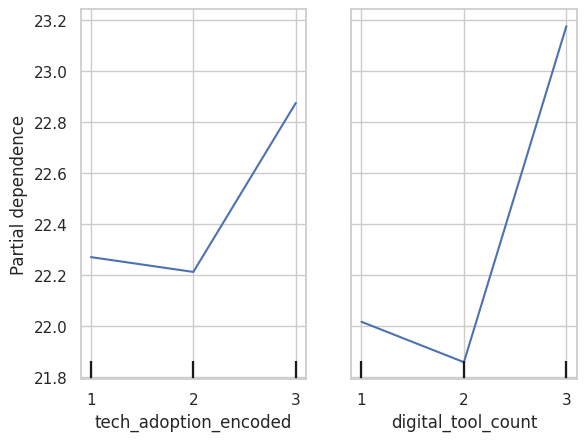

In [17]:
# 13. PARTIAL DEPENDENCE
# -------------------------

PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,
    ["tech_adoption_encoded", "digital_tool_count"]
)
plt.show()

In [18]:
# 14. CAUSAL INFERENCE – PSM + BALANCE CHECK
# -------------------------

df["high_digital"] = (df["tech_adoption_encoded"] == 3).astype(int)

ps_features = [
    "employees", "log_annual_revenue", "female_owned",
    "digital_tool_count"
]

ps_model = LogisticRegression()
ps_model.fit(df[ps_features], df["high_digital"])
df["propensity_score"] = ps_model.predict_proba(df[ps_features])[:, 1]

treated = df[df["high_digital"] == 1]
control = df[df["high_digital"] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[["propensity_score"]])

_, idx = nn.kneighbors(treated[["propensity_score"]])
matched_control = control.iloc[idx.flatten()]

ate_psm = treated["growth_last_yr"].mean() - matched_control["growth_last_yr"].mean()
print("ATE (PSM):", ate_psm)

ATE (PSM): 1.5337243401759544


In [19]:
# 15. CAUSAL ROBUSTNESS – IPW
# -------------------------

df["weight"] = np.where(
    df["high_digital"] == 1,
    1 / df["propensity_score"],
    1 / (1 - df["propensity_score"])
)

ate_ipw = (
    np.average(df[df["high_digital"] == 1]["growth_last_yr"],
               weights=df[df["high_digital"] == 1]["weight"])
    -
    np.average(df[df["high_digital"] == 0]["growth_last_yr"],
               weights=df[df["high_digital"] == 0]["weight"])
)

print("ATE (IPW):", ate_ipw)

ATE (IPW): 1.2199537495639916
